Take Home Assignment 02: Liquid Level

S.Sinthusan

EGT/20/561

1. Plot of the liquid level.

In [39]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

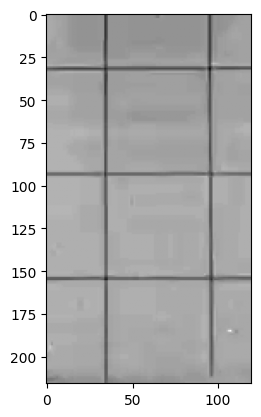

In [40]:
# Reading frames from a video
cap = cv2.VideoCapture('liquidVideo.mp4')

# Read the first frame as the background image (frame 0)
ret, frame_bg = cap.read()

# Convert the first frame to grayscale
frame_bg_gray = cv2.cvtColor(frame_bg, cv2.COLOR_BGR2GRAY)

#display the first frame
plt.imshow(frame_bg_gray, cmap='gray')
plt.show()

In [41]:

# To calculte the Liquid level 
liquid_levels_percentage = []
liquid_levels_pixels = []
frame_count = 0 

#loop through the video frames
while(cap.isOpened()):
    # Read a frame from the video
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert the frame to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Subtract the background from the current frame
    img_sub = cv2.subtract(frame_bg_gray, frame_gray)

    # Thresholding to get a binary image
    ret, img_th = cv2.threshold(img_sub, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours in the thresholded image
    contours, hierarchy = cv2.findContours(img_th, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Sort the contours by size in descending order
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Calculate the area of the largest contour
    rows, cols = img_th.shape
    total_area = rows * cols
    if contours:
        largest_contour_area = cv2.contourArea(contours[0])
        liquid_level_percentage = round((largest_contour_area / total_area) * 100, 1)
        liquid_level_pixel = largest_contour_area  # Pixel area of the largest contour
    else:
        liquid_level_percentage = 0  # No contour detected, liquid level is 0
        liquid_level_pixel = 0

    # Store the liquid level for plotting
    liquid_levels_percentage.append(liquid_level_percentage)
    liquid_levels_pixels.append(liquid_level_pixel)

    # Increment frame count
    frame_count += 1

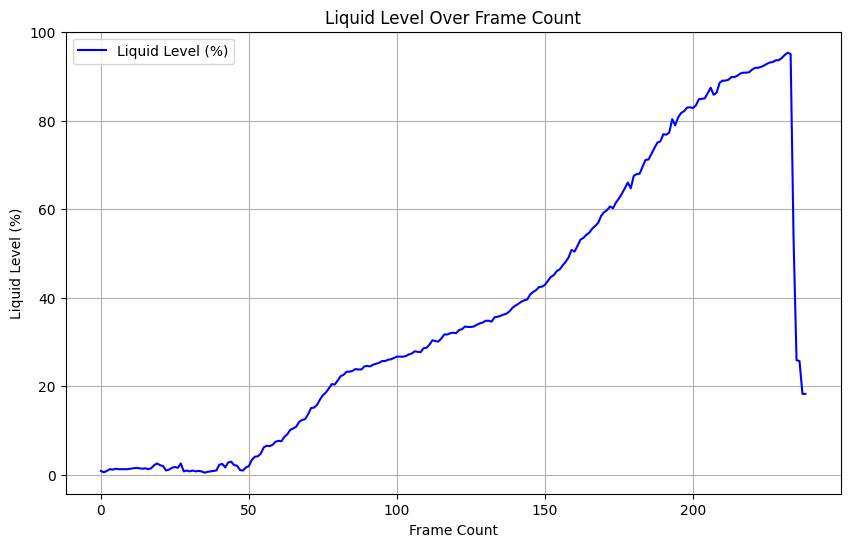

In [42]:
# Create a new figure for the plot
plt.figure(figsize=(10, 6))

# Plot the liquid level percentage over frame count
plt.plot(range(frame_count), liquid_levels_percentage, label='Liquid Level (%)', color='b')

# Set the labels and title
plt.xlabel('Frame Count')
plt.ylabel('Liquid Level (%)')
plt.title('Liquid Level Over Frame Count')

# Add a grid and legend
plt.grid(True)
plt.legend(loc='upper left')

# Show the plot
plt.show()

2. A brief note on what the student understood by reading the section on Otsu's threholding method.

Otsu's method finds the best threshold to separate the foreground and background in an image automatically. It works well for images with two distinct areas, like light and dark regions, and is useful for tasks like object detection or document scanning.

3. 2 examples of probable erroraneous liquid level readings, when using Otsu's method. Show with annoted images.


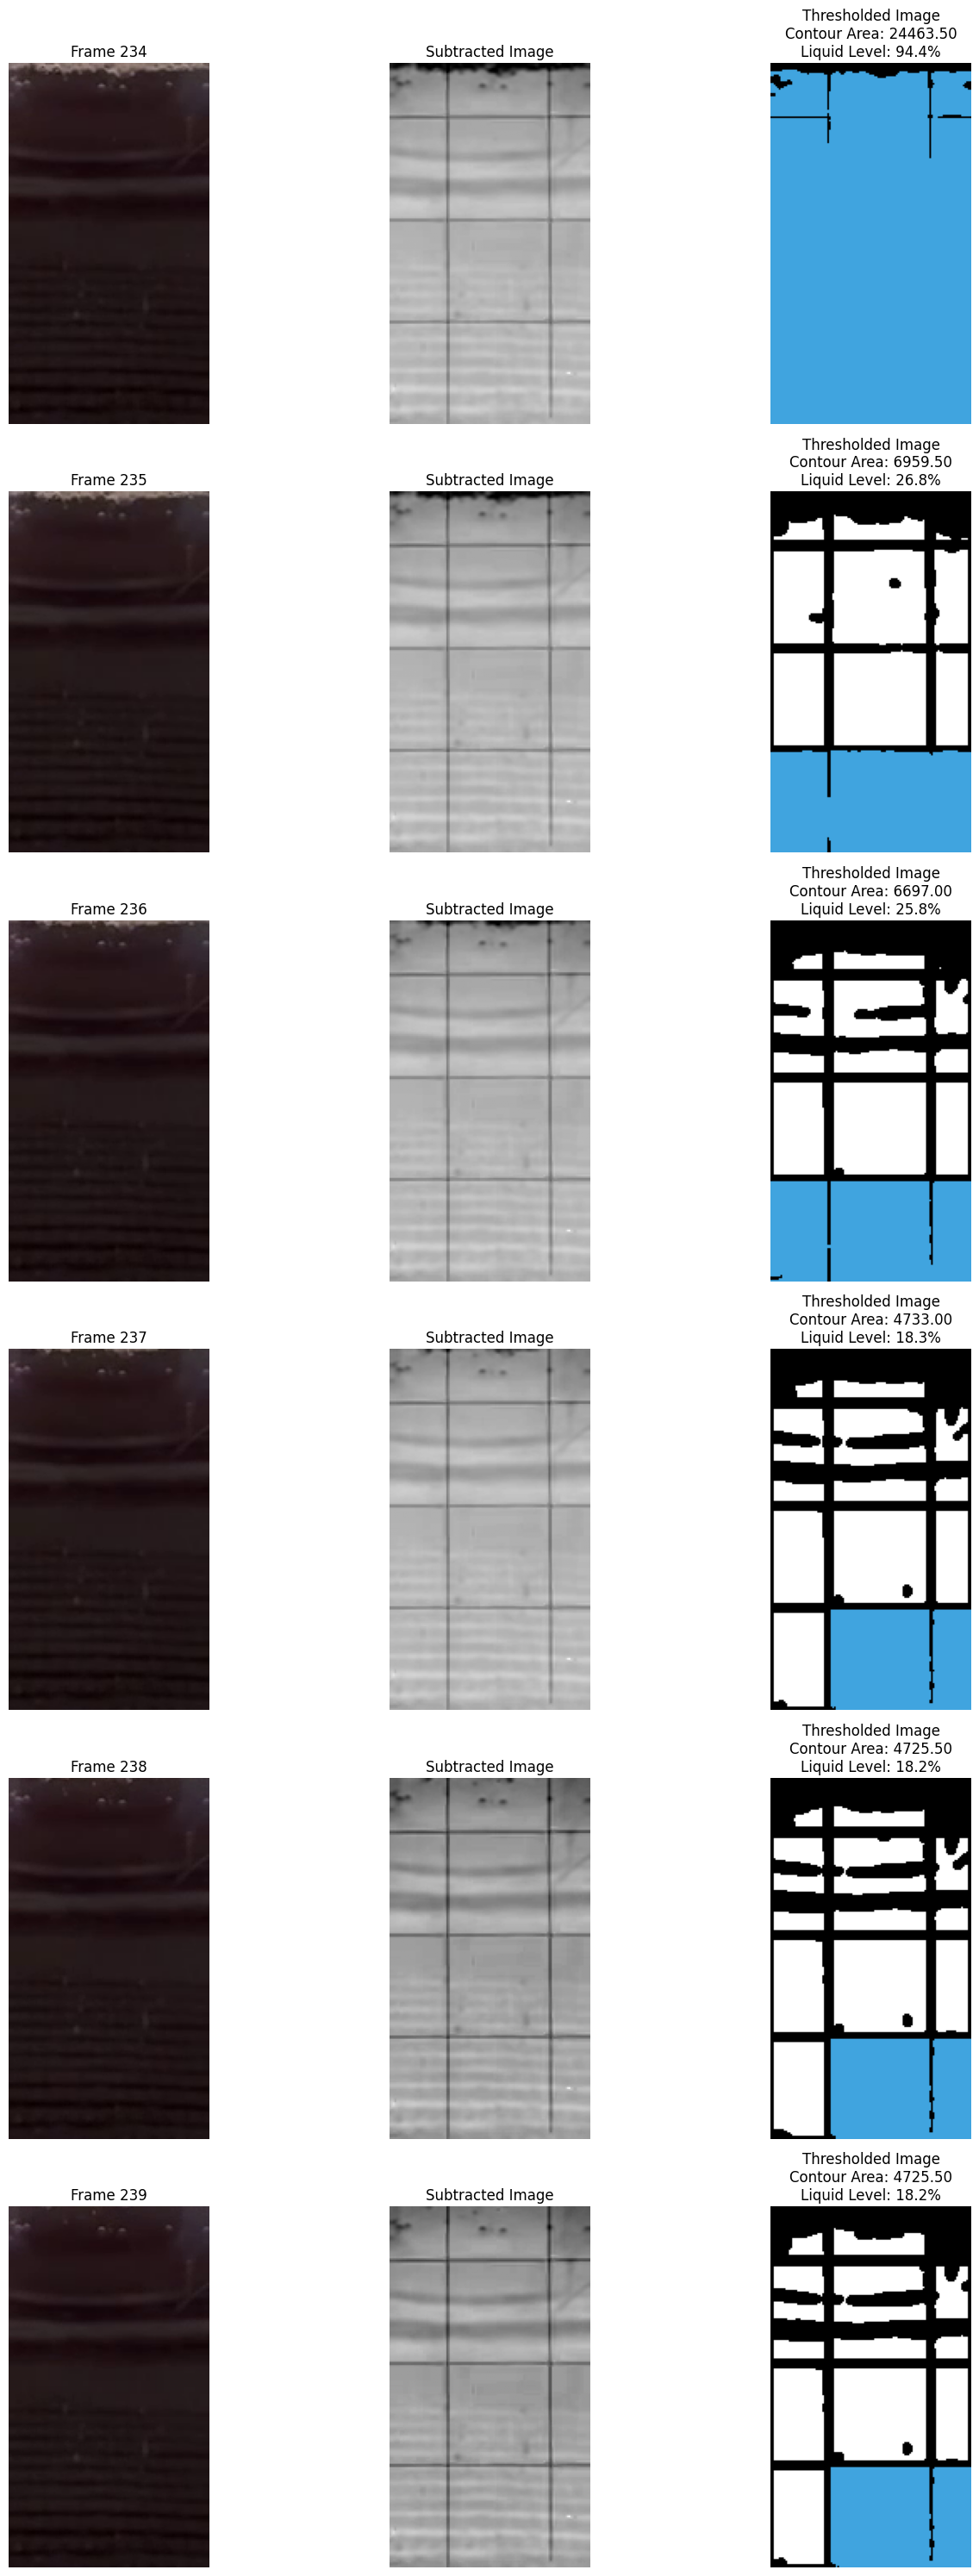

In [43]:
# Get the total number of frames in the video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Select the last 6 frames
last_frames = range(total_frames - 6, total_frames)

# Create a figure with subplots
fig, axes = plt.subplots(len(last_frames), 3, figsize=(15, 30))

for i, frame_idx in enumerate(last_frames):
    # Set the video to the specific frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    
    # Read the frame
    ret, frame = cap.read()
    if not ret:
        continue

    blur_frame = cv2.GaussianBlur(frame, (5, 3), 0)
    
    # Convert the frame to grayscale
    frame_gray = cv2.cvtColor(blur_frame, cv2.COLOR_BGR2GRAY)
    
    # Subtract the background from the current frame
    img_sub = cv2.subtract(frame_bg_gray, frame_gray)
    
    # Thresholding to get a binary image
    ret, img_th = cv2.threshold(img_sub, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find contours in the thresholded image
    contours, hierarchy = cv2.findContours(img_th, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort the contours by size in descending order
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # Area of the largest contour
    largest_contour_area = cv2.contourArea(contours[0]) if contours else 0
    liquid_level_percentage = round((largest_contour_area / total_area) * 100, 1) if contours else 0

    # Draw the contour in the thresholded image
    img_th = cv2.cvtColor(img_th, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(img_th, contours, -1, (0, 0, 0), 2)

    # Shade the area of the largest contour in the thresholded image
    if contours:
        cv2.fillPoly(img_th, pts=[contours[0]], color=(64, 164, 223))
        
    # Display the current frame
    axes[i, 0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title(f'Frame {frame_idx}')
    axes[i, 0].axis('off')
    
    # Display the subtracted image
    axes[i, 1].imshow(img_sub, cmap='gray')
    axes[i, 1].set_title('Subtracted Image')
    axes[i, 1].axis('off')
    
    # Display the thresholded image with contour area and liquid percentage
    axes[i, 2].imshow(img_th, cmap='gray')
    axes[i, 2].set_title(f'Thresholded Image\nContour Area: {largest_contour_area:.2f}\nLiquid Level: {liquid_level_percentage:.1f}%')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

# Release the video capture object
cap.release()


The potential issues with Otsu's method can be seen in the results. The main problem with this technique occurs when trying to distinguish the liquid level from the background, especially when the fluid reaches its highest point.

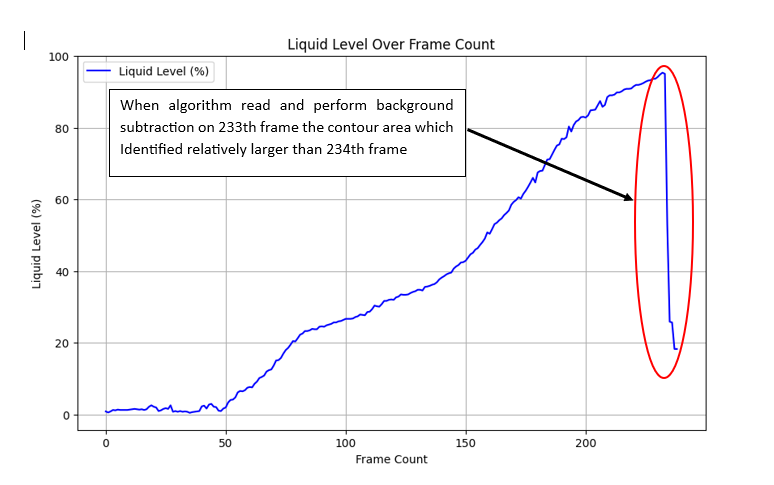

When the fluid level nears its maximum, the distinction between the fluid and the background becomes more evident, making it easier to define the contour area. However, at the maximum fluid level, the difference between the fluid and the background becomes negligible, as the entire frame may appear as a uniform color with no noticeable variations in brightness or contrast. This poses challenges for the thresholding technique, as it struggles to accurately differentiate the contours due to the lack of contrast with the background.

As a result, instead of identifying the liquid level as a single, continuous contour, the algorithm may interpret it as multiple separate contours. Consequently, the largest contour area detected appears smaller compared to previous frames. This leads the algorithm, when processing the 234th frame, to mistakenly indicate a decrease in the fluid level.

4. A brief description on the final algorithm developed by the student.

1. Select Background Frame: Choose the first frame of the video as the background image and convert it to grayscale.

2. Background Subtraction: For each following frame, convert it to grayscale and subtract the background grayscale image to highlight the differences, such as the liquid level.

3. Preprocessing: Apply thresholding to the difference image from the subtraction process to make the contours more visible.

4. Contour Detection: Use the `cv2.findContours` function to detect the contours in the thresholded image.

5. Identify Largest Contour: Identify the largest contour, which should correspond to the liquid level in the container.

6. Calculate Liquid Level Percentage: Calculate the liquid level percentage by comparing the vertical position of the largest contour to the total height of the container.

7. Store Liquid Level Percentage: For each frame, store the calculated liquid level percentage along with the frame number.

8. Plot Liquid Level Over Time: After processing all frames, plot a graph showing the liquid level percentage over time (or frame count) using a plotting library like `matplotlib`.